J41112 Шваб Кирилл
# <center>Лабораторная работа 3</center>
<center>Вариант 15</center>

## Задание 1
***Условие:***

Пусть цена **Европейского Put** опциона с $X=500\$$ равна $20\$,$ а текущая цена акции равна $S=477\$.$ Найдите цену **Американского Call** опциона с тем же страйком, если $r = 5\%$ и $T = 1.$ Ответ округлите до целых.

***Решение:***

Цены Европейских Put и Call опционов с одинаковыми параметрами связаны формулой: $$C-P=S(t)-Xe^{-r(T-t)}$$

$$C=S(t)-Xe^{-r(T-t)}+P$$

In [1]:
from math import exp

def ex_1(s=477,x = 500, r = 5, dt = 1, put = 20):
    """Задание 1. Вычисление Call опциона"""
    return round(s - x * exp(-r/100 * dt) + put, 2)

In [2]:
ex_1()

21.39

Цена **Европейского Call** опциона равна $21,39\$.$

Однако цена **Американского Call** опциона равна цене **Европейского**, т.е. в каждый момент времени, при любой цене базового актива, досрочное исполнение **Call** опциона не является оптимальным.

<u>**Ответ:**</u> цена **Американского Call** опциона при заданных параметрах **Европейского Put** опциона равна $21,39\$$

### Задание 2

Реализуем функции для подсчета:
- Fair Value Европейских опционов
- Payoff европейских опционов

In [3]:
from math import log, sqrt, exp
from scipy.stats import norm
import numpy as np
from scipy.special import comb

import matplotlib.pyplot as plt
import math

from optionprice import Option

Укажем заранее параметры для опциона

In [4]:
cdf = norm.cdf
ASSET_PRICE = 130
STRIKE_PRICE = 130
SIGMA = 0.2
R = 0.05
T = 3

N = np.arange(20, 401)

Определим функции для **fair value** и **payoff** опиционов

In [5]:
# Справедливая цена для европейского Колл опциона
def fair_value_call(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T):
    return cdf(d1(s, x, r, sigma, t)) * s - cdf(d2(s, x, r, sigma, t)) * x * exp(-r * t)


# Справедливая цена для европейского Пут опциона
def fair_value_put(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T):
    return cdf(-d2(s, x, r, sigma, t)) * x * exp(-r * t) - cdf(-d1(s, x, r, sigma, t)) * s


def d1(s, x, r, sigma, t):
    return (log(s / x) + (r + pow(sigma, 2) / 2) * t) / (sigma * sqrt(t))


def d2(s, x, r, sigma, t):
    return d1(s, x, r, sigma, t) - sigma * sqrt(t)


# Payoff для Call опциона
def payoff_call(s=ASSET_PRICE, x=STRIKE_PRICE):
    return max(s - x, 0)


# Payoff для Put опциона
def payoff_put(s=ASSET_PRICE, x=STRIKE_PRICE):
    return max(x - s, 0)


- Цены на $i$-том шаге из цен $i+1$-го шага

$$V=e^{-rdt}(pV^++(1-p)V^-)$$

In [6]:
def price_i(v_up, v_down, p, r, t):
    return exp(-r * t) * (p * v_up + (1 - p) * v_down)

- Цен **Европейских** опционов при помощи биномиальной модели

$$C=e^{-rT}\cdot\sum_{i=0}^{n}{n \choose i}p^{i}(1-p)^{n-i}\cdot max(Su^{i}d^{n-i}-X,0)$$

$$P=e^{-rT}\cdot\sum_{i=0}^{n}{n \choose i}p^{i}(1-p)^{n-i}\cdot max(X-Su^{i}d^{n-i},0)$$

$$u = e^{\sigma \sqrt{δ t}}$$
$$d = e^{-\sigma \sqrt{δ t}}$$
$$p = \frac{e^{r δ t}-d}{u-d}$$


In [7]:
def binominal_call(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T, n=N):
    """Биномиальная модель для европейского Call опциона"""
    dt = t / n
    return (exp(-r * t) *
            np.sum([comb(n, i) * p(sigma, dt, r)**i * (1 - p(sigma, dt, r))**(n - i) *
                    payoff_call(s * u(sigma, dt)**i * d(sigma, dt)**(n - i), x=x) for i in range(n)]))


def binominal_put(s=ASSET_PRICE, x=STRIKE_PRICE, r=R, sigma=SIGMA, t=T, n=N):
    """Биномиальная модель для европейского Put опциона"""
    dt = t / n
    return (exp(-r * T) *
            np.sum([comb(n, i) * p(sigma, dt, r)**i * (1 - p(sigma, dt, r))**(n - i) *
                    payoff_put(s * u(sigma, dt)**i * d(sigma, dt)**(n - i), x) for i in range(n)]))

# Функции для расчета парметров u, d, p

def u(sigma, dt):
    return exp(sigma * sqrt(dt))


def d(sigma, dt):
    return exp(-sigma * sqrt(dt))


def p(sigma, dt, r):
    return (exp(r * dt) - d(sigma, dt)) / (u(sigma, dt) - d(sigma, dt))


- Цены **Американского Put** опциона при помощи биномиальной модели

1. Рассчитываем $δt$, $u$, $d$,$p$

2. Рассчитываем цены опциона, соответствующие ценам базового актива на последнем уровне дерева (т.е. просто подставим* $S_{j,i}=Su^{i}d^{j-i}$ *в функцию выплат, получая* $C_{n,i}$ *или* $P_{n,i}$)

3) Из цен опционов на шаге j+1 получаем состояние на шаге j:
$$C_{i,j}=max[Su^{i}d^{j-i}-X, e^{-rδt}(pC_{j+1,i+1}+(1-p)C_{j+1,i})]$$
$$P_{i,j}=max[X-Su^{i}d^{j-i}, e^{-rδt}(pP_{j+1,i+1}+(1-p)P_{j+1,i})]$$

In [8]:
def binominal_american_price(s=ASSET_PRICE, x=STRIKE_PRICE, n=N, sigma=SIGMA, r=R, t=T, type=None):
    """Биномиальная модель американского опциона"""
    # Расчитываем коэффициенты u, d, p, dt
    dt = t / n
    u_value = u(sigma, dt)
    d_value = d(sigma, dt)
    p_value = p(sigma, dt, r)

    # Создаем дерево длинной N
    tree = {i: [] for i in range(n + 1)}
    tree[0].append(s)

    # Прямой ход заполнения дерева
    for i in range(1, n + 1):
        for j in range(len(tree[i - 1])):
            if j == 0:
                tree[i].append(tree[i - 1][j] * u_value)
                tree[i].append(tree[i - 1][j] * d_value)
            else:
                tree[i].append(tree[i - 1][j] * d_value)

    if type == 'Put':
        # Расчет Payoff для итоговых значений опциона в момент Maturity Date
        for i in range(n + 1):
            tree[n][i] = payoff_put(tree[n][i], x)

        # Обратный ход заоплнения дерева
        for i in range(n - 1, -1, -1):
            for j in range(len(tree[i])):
                tree[i][j] = max(payoff_put(tree[i][j], x),
                                 price_i(tree[i + 1][j], tree[i + 1][j + 1], p_value, r, dt))

    elif type == 'Call':
        # Расчет Payoff для итоговых значений опциона в момент Maturity Date
        for i in range(n + 1):
            tree[n][i] = payoff_call(tree[n][i], x)

        # Обратный ход заоплнения дерева
        for i in range(n - 1, -1, -1):
            for j in range(len(tree[i])):
                tree[i][j] = max(payoff_call(tree[i][j], x),
                                 price_i(tree[i + 1][j], tree[i + 1][j + 1], p_value, r, dt))

    return tree[0][0]


Запишем значения моделей в отрезке N

In [9]:
# Построим графики зависимости цен в биномиальной модели от числа шагов N
bin_american_put_arr = [binominal_american_price(n=i, type='Put') for i in N]
bin_american_call_arr = [binominal_american_price(n=i, type='Call') for i in N]

bin_put_arr = [binominal_put(n=i) for i in N]
bin_call_arr = [binominal_call(n=i) for i in N]

fair_value_call_arr = [fair_value_call() for i in N]
fair_value_put_arr = [fair_value_put() for i in N]


Получим значения из библиотечной функции

In [10]:
# Расчет цены Американского опциона при помощи библиотеки Option-Price при N=2000
option_price_result = []

# Так как по условию задачи T = 3, то установим в Option t = 1095, что равняется количествую дней за 3 года
for i in N:
    option_price_result.append(Option(european=False, kind='put',\
        s0=130, k=130, r=0.05, sigma=0.2, dv=0, t=1095)\
        .getPrice(method='BT', iteration=2000))

Построим графики

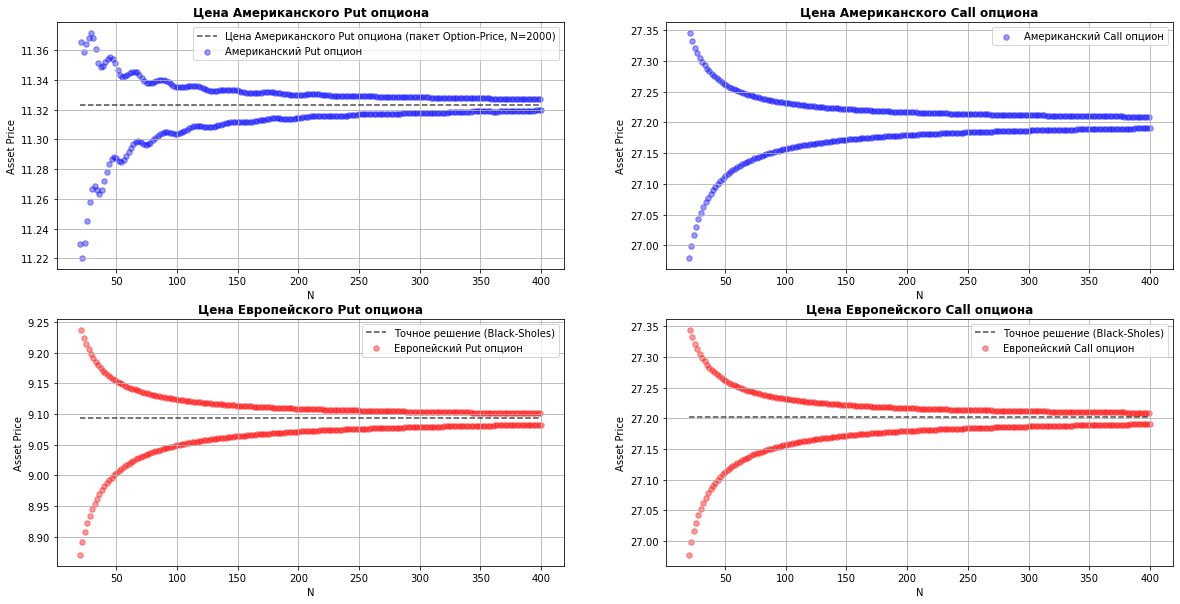

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)

plt.grid()
plt.scatter(N, bin_american_put_arr, c='blue', alpha=0.4, s=30, label='Американский Put опцион')
plt.plot(N, option_price_result , c='black', ls='--', alpha=0.7, label='Цена Американского Put опциона (пакет Option-Price, N=2000)')
plt.title('Цена Американского Put опциона', fontweight="bold")
plt.xlabel('N')
plt.ylabel('Asset Price')
plt.legend()

plt.subplot(2, 2, 2)
plt.grid()
plt.scatter(N, bin_american_call_arr, c='blue', alpha=0.4, s=30, label='Американский Call опцион')
plt.title('Цена Американского Call опциона', fontweight="bold")
plt.xlabel('N')
plt.ylabel('Asset Price')
plt.legend()

plt.subplot(2, 2, 3)
plt.grid()
plt.scatter(N, bin_put_arr, c='red', alpha=0.4, s=30, label='Европейский Put опцион')
plt.plot(N, fair_value_put_arr, c='black', ls='--', alpha=0.7, label='Точное решение (Black-Sholes)')
plt.title('Цена Европейского Put опциона', fontweight="bold")
plt.xlabel('N')
plt.ylabel('Asset Price')
plt.legend()

plt.subplot(2, 2, 4)
plt.grid()
plt.scatter(N, bin_call_arr, c='red', alpha=0.4, s=30, label='Европейский Call опцион')
plt.plot(N, fair_value_call_arr, c='black', ls='--', alpha=0.7, label='Точное решение (Black-Sholes)')
plt.title('Цена Европейского Call опциона', fontweight="bold")
plt.xlabel('N')
plt.ylabel('Asset Price')
plt.legend()
plt.show()

Из получившихся результатов видно, что цена **Американского** и **Европейского Call** опционов совпадает. Цена **Американского Put** опциона во всех точках выше, чем цена **Европейского Put** опциона. Кроме того, можно заметить, что при увеличении количества шагов цена **Европейских** опционов стремится к своему точному значению, рассчитанному по формуле **Блэка-Шоулза**.

***2.3*** Поменяйте страйк на $X=107\$$ и постройте график цен для **Европейского Call** опциона. Как изменилось поведение? Каковы могут быть причины таких изменений?

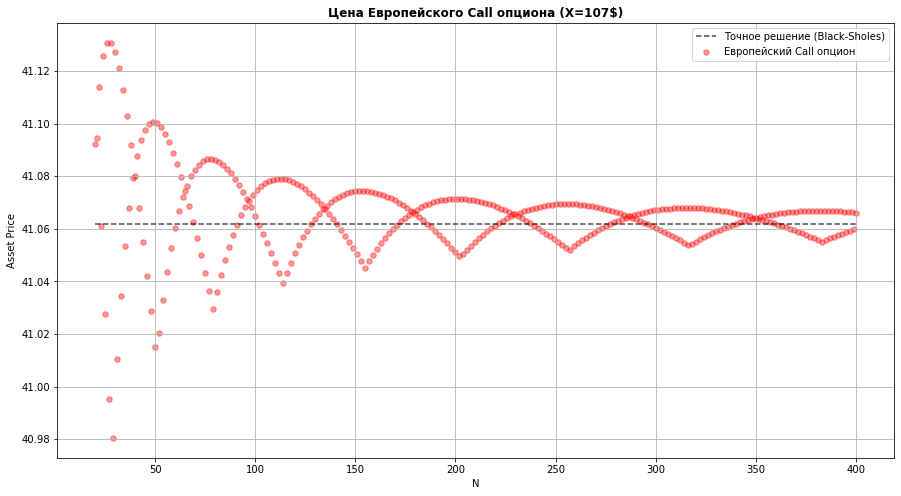

In [12]:
binominal_edited_call_arr = [binominal_call(x = 107,n = i) for i in N]
black_shoels_call_arr = [fair_value_call(x = 107) for i in N]


plt.figure(figsize=(15, 8))
plt.grid()
plt.scatter(N, binominal_edited_call_arr, c='red', alpha=0.4, s=30, label='Европейский Call опцион')
plt.plot(N, black_shoels_call_arr , c='black', ls='--', alpha=0.7, label='Точное решение (Black-Sholes)')
plt.title('Цена Европейского Call опциона (X=107$)', fontweight="bold")
plt.xlabel('N')
plt.ylabel('Asset Price')
plt.legend(loc='best')
plt.show()